# -----------------------------------------------
# CNN en FER2013
# -----------------------------------------------

## 1.- Importación de librerias

In [27]:
# Librerias de imagenes y procesamiento de imagenes
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Libreria del sistema
import os
import pickle

# Librerias de Deep Learning
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Librerias de métricas
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Librerias de procesamiento de data
import numpy as np
import pandas as pd

## 2.- Parámetros

In [11]:
# Emociones
emotions = {'angry' : 0, 'disgust' : 1, 'fear' : 2, 'happy' : 3, 'sad' : 4, 'surprise' : 5, 'neutral' : 6}
emotions_inv = {v: k for k, v in emotions.items()}

num_classes = len(emotions)

# Rutas 
path_data = '../0_Inputs/fer2013.csv'

# Pixeles
img_width, img_height = 48, 48

## 3.- Procesamiento

In [12]:
# Leyendo la información
data = pd.read_csv(path_data)
data['pixels'] = data["pixels"].astype(str).str.split(" ").tolist()
data.head()

,emotion,pixels,Usage
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Training
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Training
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",Training
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",Training
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",Training


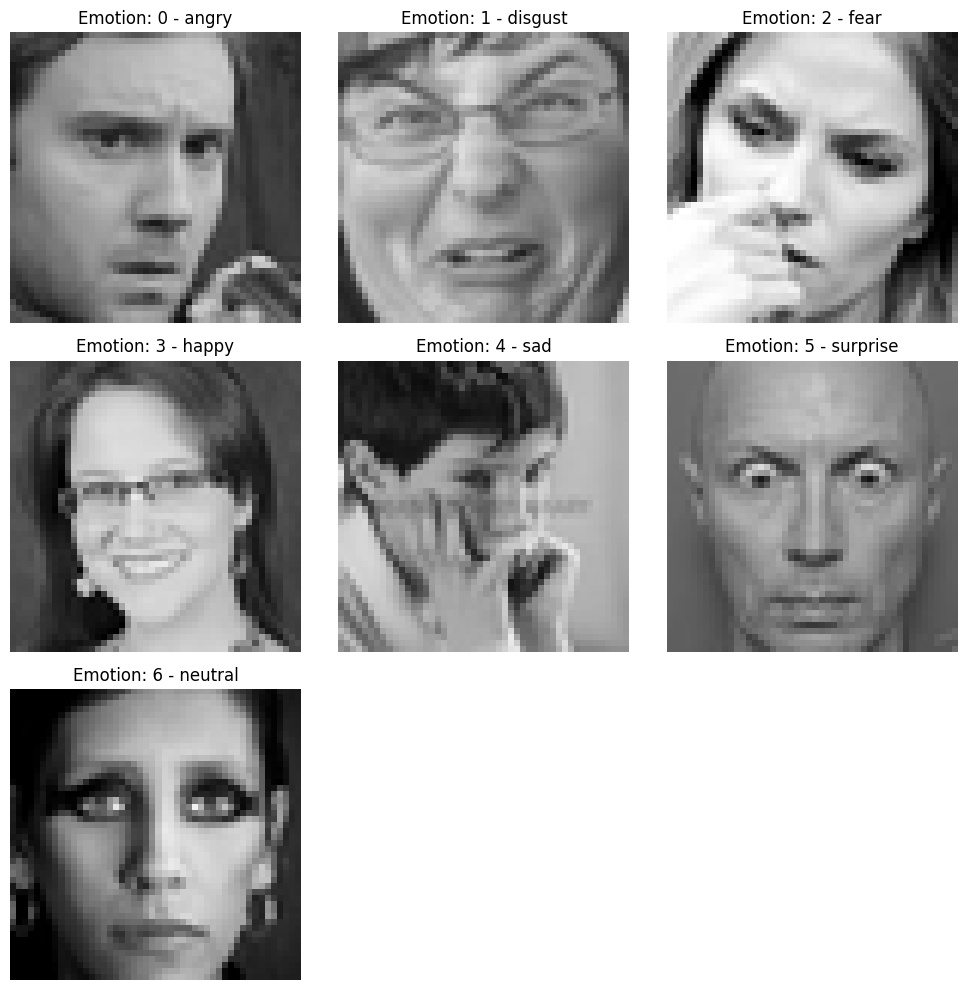

In [23]:
# Función para convertir una lista de píxeles en una imagen de 48x48
def pixels_to_image(pixels):
    # Convertir la lista en un arreglo NumPy y redimensionar a 48x48
    image_array = np.array(pixels).reshape(48, 48).astype('float32')
    # Crear una imagen a partir del arreglo NumPy
    image = Image.fromarray(image_array)
    return image

# Extraer las emociones únicas para graficar una imagen por emoción
list_emociones = data['emotion'].sort_values().unique()

# Crear una figura para graficar las imágenes correspondientes a cada emoción
plt.figure(figsize=(10, 10))

# Graficar una imagen por cada emoción
for i, emotion in enumerate(list_emociones):
    # Extraer la primera fila que corresponda a la emoción actual
    pixels = data[data['emotion'] == emotion].iloc[0]['pixels']
    
    # Convertir los píxeles a imagen
    img = pixels_to_image(pixels)
    
    # Graficar la imagen
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Emotion: {emotion} - {emotions_inv[emotion]}')
    plt.axis('off')

# Mostrar las imágenes
plt.tight_layout()
plt.show()

#### Definiendo data Train

In [24]:
# Data X Train
X_train =  data.loc[data['Usage'] == 'Training', 'pixels']
n_size_train = X_train.shape[0]
X_train = np.array(X_train.tolist()).astype('float32')
X_train /= 255.0
X_train = X_train.reshape((n_size_train, 48, 48,1))
X_train

array([[[[0.27450982],
         [0.3137255 ],
         [0.32156864],
         ...,
         [0.20392157],
         [0.16862746],
         [0.16078432]],

        [[0.25490198],
         [0.23921569],
         [0.22745098],
         ...,
         [0.21960784],
         [0.20392157],
         [0.17254902]],

        [[0.19607843],
         [0.16862746],
         [0.21176471],
         ...,
         [0.19215687],
         [0.21960784],
         [0.18431373]],

        ...,

        [[0.35686275],
         [0.25490198],
         [0.16470589],
         ...,
         [0.28235295],
         [0.21960784],
         [0.16862746]],

        [[0.3019608 ],
         [0.32156864],
         [0.30980393],
         ...,
         [0.4117647 ],
         [0.27450982],
         [0.18039216]],

        [[0.3019608 ],
         [0.28235295],
         [0.32941177],
         ...,
         [0.41568628],
         [0.42745098],
         [0.32156864]]],


       [[[0.5921569 ],
         [0.5882353 ],
         [0.57

In [28]:
# Data Y Train
y_train = data.loc[data['Usage'] == 'Training', 'emotion']
y_train =  np.array(y_train.tolist())
y_train = to_categorical(y_train, num_classes=num_classes)
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

#### Definiendo data Test

In [29]:
# Data X Test
X_test =  data.loc[data['Usage'] != 'Training', 'pixels']
n_size_test = X_test.shape[0]
X_test = np.array(X_test.tolist()).astype('float32')
X_test /= 255.0
X_test = X_test.reshape((n_size_test, 48, 48,1))
X_test

array([[[[0.99607843],
         [0.99607843],
         [0.99607843],
         ...,
         [0.0627451 ],
         [0.        ],
         [0.6313726 ]],

        [[0.99607843],
         [0.99607843],
         [0.99607843],
         ...,
         [0.06666667],
         [0.        ],
         [0.47843137]],

        [[0.99607843],
         [0.99607843],
         [0.99607843],
         ...,
         [0.10196079],
         [0.        ],
         [0.44705883]],

        ...,

        [[0.25882354],
         [0.3372549 ],
         [0.3882353 ],
         ...,
         [1.        ],
         [0.9882353 ],
         [0.99607843]],

        [[0.32941177],
         [0.36078432],
         [0.36078432],
         ...,
         [0.9254902 ],
         [1.        ],
         [1.        ]],

        [[0.3647059 ],
         [0.3529412 ],
         [0.33333334],
         ...,
         [0.16470589],
         [0.5058824 ],
         [0.7058824 ]]],


       [[[0.6117647 ],
         [0.72156864],
         [0.77

In [30]:
# Data Y Test
y_test = data.loc[data['Usage'] != 'Training', 'emotion']
y_test =  np.array(y_test.tolist())
y_test = to_categorical(y_test, num_classes=num_classes)
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

#### Tamaño de matrices

In [31]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (28709, 48, 48, 1)
y_train shape: (28709, 7)
X_test shape: (7178, 48, 48, 1)
y_test shape: (7178, 7)


## 4.- Arquitecturas CNN

#### Aumentando datos 

In [35]:
# Aumentación de datos para mejorar la generalización del modelo
datagen = ImageDataGenerator(
    rotation_range=10,  # Rotar las imágenes aleatoriamente dentro de un rango de 10 grados
    width_shift_range=0.1,  # Desplazar la imagen horizontalmente hasta un 10% del ancho
    height_shift_range=0.1,  # Desplazar la imagen verticalmente hasta un 10% de la altura
    zoom_range=0.1,  # Hacer zoom aleatorio en las imágenes
    horizontal_flip=True,  # Voltear las imágenes horizontalmente
    fill_mode='nearest'  # Rellenar los píxeles vacíos tras las transformaciones
)

# Ajustar el generador a los datos de entrenamiento
datagen.fit(X_train)

#### Arquitectura 1: CNN

In [36]:
# Definir el modelo CNN (Arquitectura 1)
cnn_model_Arq1 = Sequential()

# Primera capa de convolución con 32 filtros, tamaño de kernel 3x3, función de activación 'relu'
cnn_model_Arq1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
# Capa de max pooling para reducir el tamaño de las imágenes y evitar sobreajuste
cnn_model_Arq1.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa de convolución con 64 filtros y max pooling
cnn_model_Arq1.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_Arq1.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa de convolución con 128 filtros y max pooling
cnn_model_Arq1.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model_Arq1.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanar las características extraídas de las capas de convolución para pasarlas a las capas densas
cnn_model_Arq1.add(Flatten())
# Capa densa (fully connected) con 128 neuronas y activación 'relu'
cnn_model_Arq1.add(Dense(128, activation='relu'))
# Añadir Dropout para reducir el sobreajuste
cnn_model_Arq1.add(Dropout(0.5))

# Capa de salida con 7 neuronas (una por clase de emoción) y función de activación 'softmax'
cnn_model_Arq1.add(Dense(7, activation='softmax'))

c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Compilar el modelo CNN usando 'adam' como optimizador, pérdida categórica y métrica de precisión
cnn_model_Arq1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los datos aumentados y las etiquetas correspondientes
history_Arq1 = cnn_model_Arq1.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        validation_data=(X_test, y_test), 
                        epochs=50)  # Entrenamos durante 50 épocas


Epoch 1/50
  1/898 ━━━━━━━━━━━━━━━━━━━━ 53:48 4s/step - accuracy: 0.1875 - loss: 1.9283

c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.2348 - loss: 1.8310 - val_accuracy: 0.3192 - val_loss: 1.6774
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.3056 - loss: 1.7109 - val_accuracy: 0.4181 - val_loss: 1.5124
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3654 - loss: 1.6115 - val_accuracy: 0.4517 - val_loss: 1.4246
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4070 - loss: 1.5271 - val_accuracy: 0.4666 - val_loss: 1.3961
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4389 - loss: 1.4596 - val_accuracy: 0.5017 - val_loss: 1.3014
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4563 - loss: 1.4197 - val_accuracy: 0.4957 - val_loss: 1.3068
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4677 - loss: 1.3864 - val_accuracy: 0.5187 - val_loss: 1.2571
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4744 - loss: 1.3666 - val_accurac

In [45]:
# Función para evaluar y hacer predicciones con el modelo entrenado
def evaluate_and_predict(model, X_test, y_test, labels):
    # Hacer predicciones con el modelo
    y_pred = model.predict(X_test)
    
    # Convertir las predicciones y las etiquetas verdaderas a sus clases respectivas
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Imprimir el reporte de clasificación para ver el rendimiento en cada clase
    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=labels))
    
    return y_pred_classes

# Lista de etiquetas de emociones (basado en el dataset FER2013)
labels = [x[0] for x in emotions.items()]

# Evaluar y predecir con el modelo CNN entrenado
print("Results for CNN:")
cnn_predictions_Arq1 = evaluate_and_predict(cnn_model_Arq1, X_test, y_test, labels)
# Guardar el modelo entrenado para uso posterior
cnn_model_Arq1.save('cnn_emotion_detection_model.h5')

Results for CNN:
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:


              precision    recall  f1-score   support

       angry       0.54      0.42      0.48       958
     disgust       0.69      0.23      0.34       111
        fear       0.40      0.28      0.33      1024
       happy       0.79      0.85      0.82      1774
         sad       0.47      0.47      0.47      1247
    surprise       0.69      0.79      0.74       831
     neutral       0.49      0.65      0.56      1233

    accuracy                           0.59      7178
   macro avg       0.58      0.52      0.53      7178
weighted avg       0.58      0.59      0.58      7178



225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


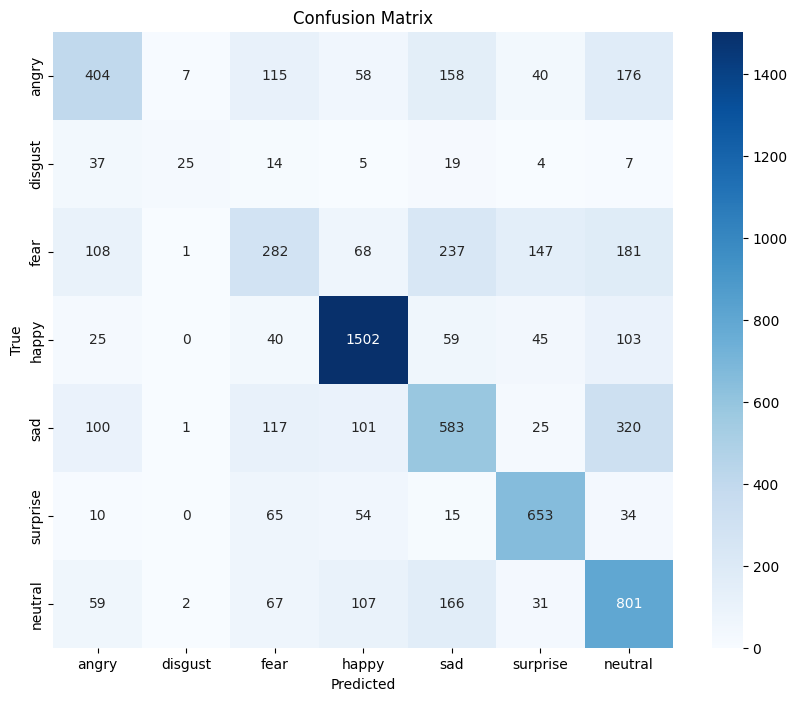

In [46]:
# True labels
y_true = np.argmax(y_test, axis=1)

# Predictions from the model
y_pred = np.argmax(cnn_model_Arq1.predict(X_test), axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

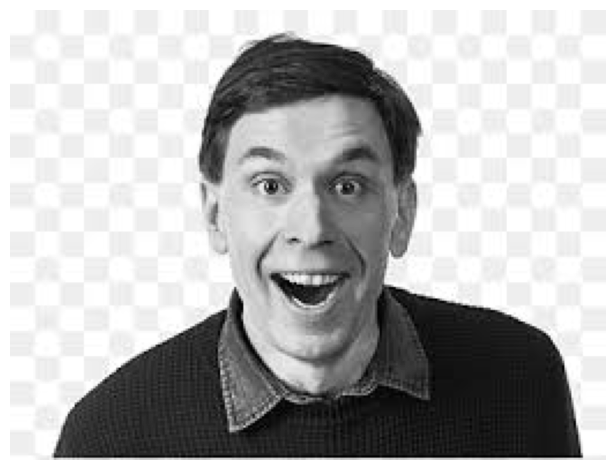

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[3]
Emoción predicha: happy


In [54]:
# Cargar el modelo entrenado de CNN
model_Arq1 = load_model('cnn_emotion_detection_model.h5')

def predict_emotion(image_path, model):
    # Cargar la imagen
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = Image.open(image_path).convert('L')
    
    
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    # Mostrar las imágenes
    plt.tight_layout()
    plt.show()
    
    
    # Redimensionar la imagen a 48x48 píxeles (el tamaño de entrada para la CNN)
    image = np.array(image.resize((48, 48)))
    
    # Reformatear la imagen para que se ajuste a la forma de entrada del modelo
    image = image.reshape(1, 48, 48, 1).astype('float32')
    
    # Normalizar los valores de los píxeles de la imagen
    image = image / 255.0
    
    # Hacer una predicción usando el modelo CNN
    prediction = model.predict(image)
    
    # Convertir la predicción a la etiqueta de clase
    predicted_class = np.argmax(prediction, axis=1)

    print(predicted_class)
    
    # Devolver la etiqueta de emoción predicha
    return labels[predicted_class[0]]

# Probar la función con una imagen
image_path = '../0_Inputs/rostro_feliz.jpg'
predicted_emotion = predict_emotion(image_path, cnn_model_Arq1)
print(f"Emoción predicha: {predicted_emotion}")


#### Arquitectura 2: CNN con clases balanceadas

In [55]:
# Definir el modelo de CNN (Arquitectura 2)
cnn_model_Arq2 = Sequential()

cnn_model_Arq2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))  # Primera capa convolucional
cnn_model_Arq2.add(MaxPooling2D(pool_size=(2, 2)))  # Capa de max-pooling

cnn_model_Arq2.add(Conv2D(64, (3, 3), activation='relu'))  # Segunda capa convolucional
cnn_model_Arq2.add(MaxPooling2D(pool_size=(2, 2)))  # Capa de max-pooling

cnn_model_Arq2.add(Conv2D(128, (3, 3), activation='relu'))  # Tercera capa convolucional
cnn_model_Arq2.add(MaxPooling2D(pool_size=(2, 2)))  # Capa de max-pooling

cnn_model_Arq2.add(Flatten())  # Aplanamiento de la salida para la entrada en la capa densa
cnn_model_Arq2.add(Dense(128, activation='relu'))  # Capa densa totalmente conectada
cnn_model_Arq2.add(Dropout(0.5))  # Dropout para evitar sobreajuste

cnn_model_Arq2.add(Dense(7, activation='softmax'))  # Capa de salida con softmax para 7 clases de emociones

# Compilar el modelo CNN con tasa de aprendizaje ajustada
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# El mismo optimizador, pero se entrenará con pesos de clase para tener en cuenta el desbalance de clases
cnn_model_Arq2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# --------------------------- Nueva Cálculo de Pesos de Clase ----------------------------
# Obtener las etiquetas únicas de y_train y calcular los pesos de clase
y_train_int = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)

# Convertir la lista de pesos de clase a un diccionario para Keras
class_weights_dict = dict(enumerate(class_weights))
print("Pesos de Clases:", class_weights_dict)

# Entrenar el modelo usando los pesos de clase
history_Arq2 = cnn_model_Arq2.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        class_weight=class_weights_dict)

# Guardar el modelo de CNN entrenado
cnn_model_Arq2.save('cnn_emotion_detection_model_balanced.h5')


# Evaluar y predecir para el modelo CNN (Arquitectura 1)
print("Resultados para CNN con Clases Balanceadas:")
cnn_predictions = evaluate_and_predict(cnn_model_Arq2, X_test, y_test, labels)

Pesos de Clases: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8491274770777877, 5: 1.293372978330405, 6: 0.8260394187886635}
Epoch 1/50


c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 11/898 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.1066 - loss: 1.7760

c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.1544 - loss: 1.9277 - val_accuracy: 0.1367 - val_loss: 1.9538
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.1926 - loss: 1.9017 - val_accuracy: 0.2339 - val_loss: 1.8456
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.2449 - loss: 1.8411 - val_accuracy: 0.2935 - val_loss: 1.7871
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.2712 - loss: 1.8067 - val_accuracy: 0.3477 - val_loss: 1.7010
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.2959 - loss: 1.7981 - val_accuracy: 0.3494 - val_loss: 1.7138
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.3102 - loss: 1.7359 - val_accuracy: 0.3848 - val_loss: 1.6427
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.3294 - loss: 1.7308 - val_accuracy: 0.3880 - val_loss: 1.6365
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.3452 - loss: 1.7223 - val_accurac

Resultados para CNN con Clases Balanceadas:
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.45      0.47      0.46       958
     disgust       0.21      0.71      0.32       111
        fear       0.41      0.18      0.25      1024
       happy       0.81      0.76      0.78      1774
         sad       0.48      0.37      0.42      1247
    surprise       0.63      0.77      0.69       831
     neutral       0.47      0.65      0.55      1233

    accuracy                           0.55      7178
   macro avg       0.49      0.56      0.50      7178
weighted avg       0.56      0.55      0.54      7178



#### Arquitectura 3: CNN con pesos de clases

In [56]:
# CNN con Pesos de Clase

# Definir el modelo CNN
cnn_model_Arq3 = Sequential()

cnn_model_Arq3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))  # Primera capa convolucional
cnn_model_Arq3.add(MaxPooling2D(pool_size=(2, 2)))  # Capa de max-pooling

cnn_model_Arq3.add(Conv2D(64, (3, 3), activation='relu'))  # Segunda capa convolucional
cnn_model_Arq3.add(MaxPooling2D(pool_size=(2, 2)))  # Capa de max-pooling

cnn_model_Arq3.add(Conv2D(128, (3, 3), activation='relu'))  # Tercera capa convolucional
cnn_model_Arq3.add(MaxPooling2D(pool_size=(2, 2)))  # Capa de max-pooling

cnn_model_Arq3.add(Flatten())  # Aplanar la salida de las capas convolucionales
cnn_model_Arq3.add(Dense(128, activation='relu'))  # Capa densa
cnn_model_Arq3.add(Dropout(0.5))  # Dropout para evitar el sobreajuste

cnn_model_Arq3.add(Dense(7, activation='softmax'))  # Capa de salida con 7 clases de emociones

# Compilar el modelo CNN
cnn_model_Arq3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ajuste de pesos de clase
class_labels = np.array([0, 1, 2, 3, 4, 5, 6])  # ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Calcular los pesos de clase basados en la distribución de los datos de entrenamiento
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=np.argmax(y_train, axis=1))

# Convertir los pesos a un diccionario para el modelo de Keras
class_weight_dict = dict(enumerate(class_weights))

# Opcionalmente, ajustar el peso para la clase 'Disgust' (Clase 1)
class_weight_dict[1] = 1.5  # Ajuste del peso para 'Disgust' para reducir falsos positivos

print("Pesos de Clase:", class_weight_dict)

# Entrenar el modelo CNN con pesos de clase
history_Arq3 = cnn_model_Arq3.fit(datagen.flow(X_train, y_train, batch_size=32),
                        validation_data=(X_test, y_test),
                        epochs=50,
                        class_weight=class_weight_dict)

# Guardar el modelo CNN
cnn_model_Arq3.save('cnn_emotion_detection_with_class_weights.h5')


# Evaluar y predecir para el modelo CNN
print("Resultados para CNN con Pesos de Clase:")
cnn_predictions = evaluate_and_predict(cnn_model_Arq3, X_test, y_test, labels)


Pesos de Clase: {0: 1.0266046844269623, 1: 1.5, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8491274770777877, 5: 1.293372978330405, 6: 0.8260394187886635}
Epoch 1/50


c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  7/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.1975 - loss: 1.6416

c:\Users\Jose\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.1867 - loss: 1.6365 - val_accuracy: 0.2772 - val_loss: 1.7190
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.2729 - loss: 1.5436 - val_accuracy: 0.3476 - val_loss: 1.6527
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.3517 - loss: 1.4553 - val_accuracy: 0.4432 - val_loss: 1.4722
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.3957 - loss: 1.3950 - val_accuracy: 0.4700 - val_loss: 1.3838
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4331 - loss: 1.3263 - val_accuracy: 0.4968 - val_loss: 1.3243
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.4510 - loss: 1.2853 - val_accuracy: 0.4919 - val_loss: 1.3296
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4675 - loss: 1.2603 - val_accuracy: 0.5199 - val_loss: 1.2621
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4805 - loss: 1.2287 - val_accurac

Resultados para CNN con Pesos de Clase:
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.48      0.56      0.52       958
     disgust       0.49      0.30      0.37       111
        fear       0.43      0.29      0.35      1024
       happy       0.83      0.78      0.81      1774
         sad       0.49      0.39      0.44      1247
    surprise       0.68      0.77      0.72       831
     neutral       0.48      0.66      0.56      1233

    accuracy                           0.58      7178
   macro avg       0.56      0.54      0.54      7178
weighted avg       0.59      0.58      0.58      7178



CNN:
Precisión de 59% en la validación, con un buen rendimiento en emociones como Happy (82%) y Surprise (74%), pero con problemas en Disgust (34%) y Fear (33%). Esto indica que el modelo tiene dificultades en clases menos representadas o más difíciles de detectar.
Conclusión: El modelo sin ajustes de pesos de clase tiene un rendimiento moderado, pero muestra un sesgo hacia las clases más frecuentes.

CNN con clases balanceadas:
Se introdujeron técnicas de balanceo, lo que ayudó a mejorar el rendimiento en Disgust (32% f1-score), pero el rendimiento general bajó a 55%, con disminuciones en otras clases como Happy (78%) y Neutral (55%).
Conclusión: Aunque el balance de clases ayudó en clases como Disgust, impactó negativamente en el rendimiento global, especialmente en emociones frecuentes.

CNN con class weight:

La precisión general fue de 58%, ligeramente mejor que la segunda versión. Clases difíciles como Fear mejoraron (35% f1-score), mientras que Disgust también mejoró (37%).
Conclusión: El uso de pesos de clase ajustados manualmente, especialmente en clases difíciles como Disgust, mostró un impacto positivo sin afectar tanto las clases más frecuentes.

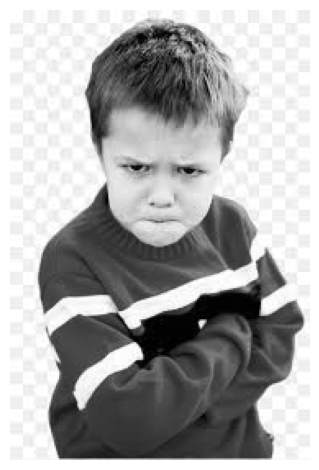

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[3]
Emoción predicha: happy


In [67]:
# Probar la función con una imagen
image_path = '../0_Inputs/rostro_disgustado.jpg'
predicted_emotion = predict_emotion(image_path, cnn_model_Arq1)
print(f"Emoción predicha: {predicted_emotion}")

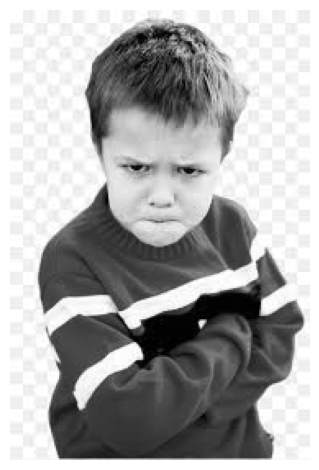

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0]
Emoción predicha: angry


In [70]:
# Probar la función con una imagen
image_path = '../0_Inputs/rostro_disgustado.jpg'
predicted_emotion = predict_emotion(image_path, cnn_model_Arq3)
print(f"Emoción predicha: {predicted_emotion}")